# Independent Component Analysis (ICA) for removing biological artefacts

In [2]:
# Authors: Denis Engemann <denis.engemann@gmail.com>
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#
# License: BSD (3-clause)

import numpy as np

import mne
from mne.io import Raw
from mne.datasets import sample

In [3]:
# ICA related functionality
from mne.preprocessing import ICA, read_ica
from mne.preprocessing import create_ecg_epochs, create_eog_epochs

In [4]:
# getting some data ready
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = Raw(raw_fname, preload=True)
raw.filter(1, 45, n_jobs=2)

Opening raw data file /Users/dengemann/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
Current compensation grade : 0
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Band-pass filtering from 1 - 45 Hz


[Parallel(n_jobs=2)]: Done   1 out of 366 | elapsed:    0.0s remaining:    4.8s
[Parallel(n_jobs=2)]: Done  72 out of 366 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=2)]: Done 146 out of 366 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=2)]: Done 220 out of 366 | elapsed:    0.7s remaining:    0.5s
[Parallel(n_jobs=2)]: Done 294 out of 366 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=2)]: Done 366 out of 366 | elapsed:    1.1s finished


<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec)>

In [5]:
# as usual we re picky
picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=False,
                           stim=False, exclude='bads')
# we start by looking at magnetometer and gradiometer signals

# Before fitting models let's look at what we want to get rid off

Reconstructing ECG signal from Magnetometers
Reconstructing ECG signal from Magnetometers
Number of ECG events detected : 284 (average pulse 61 / min.)
Creating RawArray with float64 data, n_channels=1, n_times=41700
    Range : 0 ... 41699 =      0.000 ...   277.709 secs
Ready.
284 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Loading data for 284 events and 151 original time points ...
    Rejecting  epoch based on MAG : [u'MEG 1711']
    Rejecting  epoch based on MAG : [u'MEG 1711']
    Rejecting  epoch based on MAG : [u'MEG 1411', u'MEG 1421']
    Rejecting  epoch based on MAG : [u'MEG 1331']
    Rejecting  epoch based on MAG : [u'MEG 1411']
    Rejecting  epoch based on MAG : [u'MEG 1411']
6 bad epochs dropped


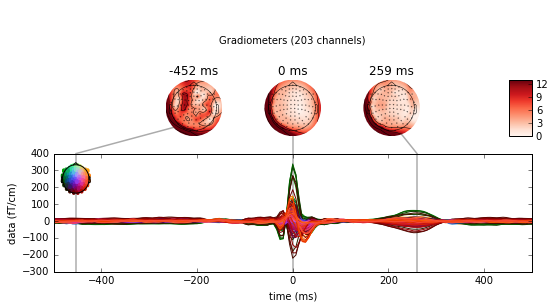

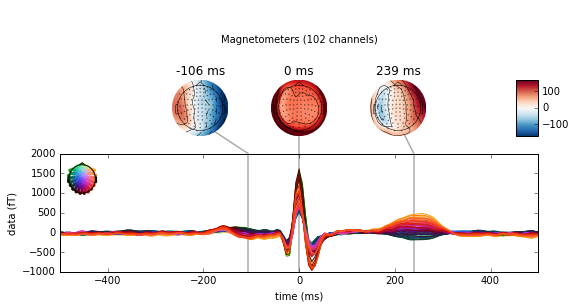

In [6]:
%matplotlib inline 
# ECG
reject = dict(mag=4e-12, grad=4000e-13)  # don't fit on crazy environmental artefacts
ecg_average = create_ecg_epochs(raw, reject=reject, picks=picks_meg).average()
ecg_average.plot_joint();
# What is the order of magnitude of the average artefact?
# Do we see different spatial patterns?

EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Now detecting blinks and generating corresponding events
Number of EOG events detected : 46
46 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Loading data for 46 events and 151 original time points ...
    Rejecting  epoch based on MAG : [u'MEG 1411', u'MEG 1421']
    Rejecting  epoch based on MAG : [u'MEG 1411']
    Rejecting  epoch based on MAG : [u'MEG 1411']
3 bad epochs dropped


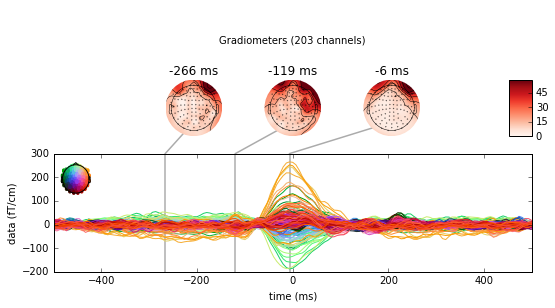

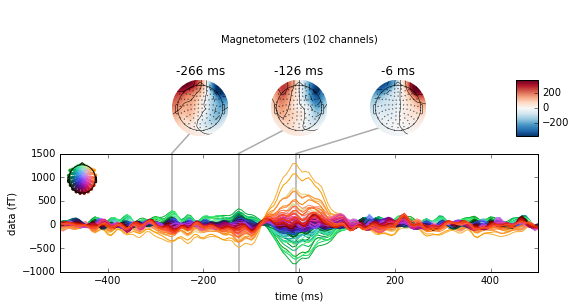

In [7]:
# EOG
reject = dict(mag=4e-12, grad=4000e-13)  # don't fit on crazy environmental artefacts
eog_average = create_eog_epochs(raw, reject=reject, picks=picks_meg).average()
eog_average.plot_joint();

# Fit ICA model using the FastICA algorithm

In [8]:
# ICA parameters
n_components = 25  # if float, select the number components by explained variance of PCA
method = 'fastica'  # for comparison with EEGLAB try "extended-infomax" here
decim = 3  # we only need enough statistics, not all time points

In [9]:
# Let's fit 
ica = ICA(n_components=n_components, method=method)
print(ica)
ica.fit(raw, picks=picks_meg, decim=decim, reject=reject)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
Fitting ICA to data using 305 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
    Rejecting  epoch based on MAG : [u'MEG 1711']
Artifact detected in [4242, 4343]
    Rejecting  epoch based on MAG : [u'MEG 1711']
Artifact detected in [5858, 5959]
    Rejecting  epoch based on MAG : [u'MEG 1411']
Artifact detected in [13433, 13534]
Selection by number: 25 components
<ICA  |  raw data decomposition, fit (fastica): 13534 samples, 25 components, channels used: "mag"; "grad">


# Plot ICA components

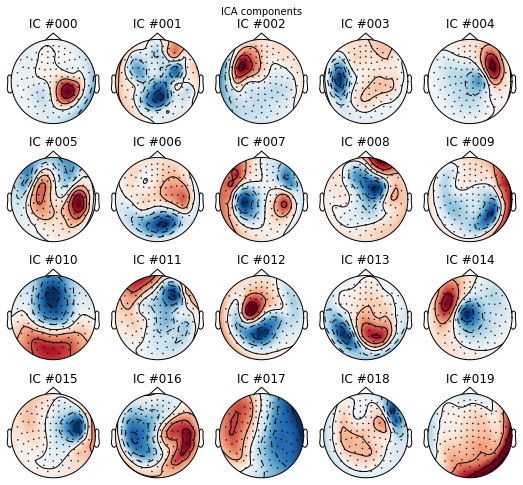

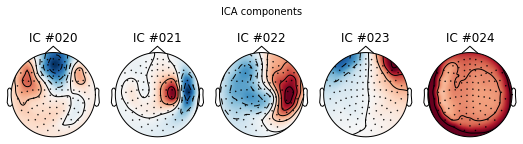

In [17]:
ica.plot_components()  # can you see some potential bad guys?

# Let's use a more efficient way to find artefacts

In [18]:
# We simplify the detection game by setting the maximum number of components to reject
n_max_eog = 1  # here we bet on finding the vertical EOG components
eog_epochs = create_eog_epochs(raw, reject=reject)  # get single EOG trials
eog_inds, scores = ica.find_bads_eog(eog_epochs)  # find indices via correation

EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Now detecting blinks and generating corresponding events
Number of EOG events detected : 46
46 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 4)
Loading data for 46 events and 151 original time points ...
    Rejecting  epoch based on MAG : [u'MEG 1411', u'MEG 1421']
    Rejecting  epoch based on MAG : [u'MEG 1411']
    Rejecting  epoch based on MAG : [u'MEG 1411']
3 bad epochs dropped


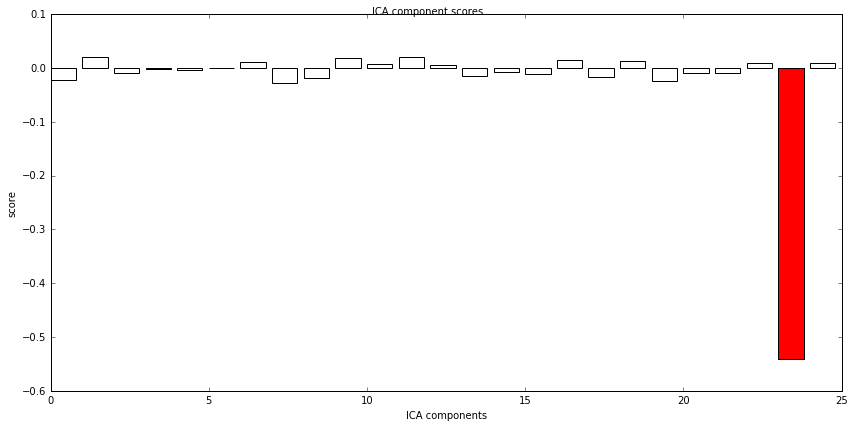

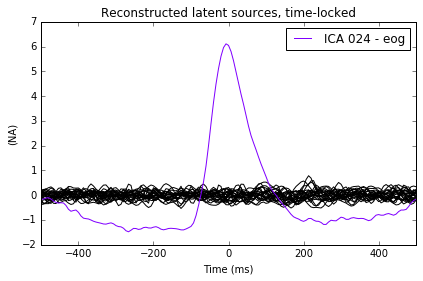

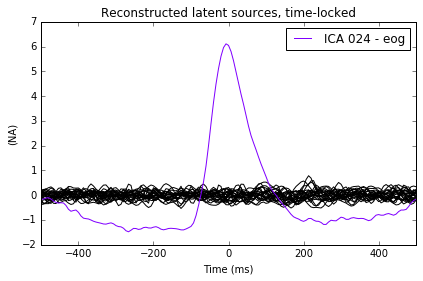

In [19]:
ica.plot_scores(scores, exclude=eog_inds)  # look at correlation with components
ica.plot_sources(eog_average, exclude=eog_inds);  # look at source time course

Using matplotlib backend: MacOSX
Transforming to ICA space (25 components)
Zeroing out 1 ICA components


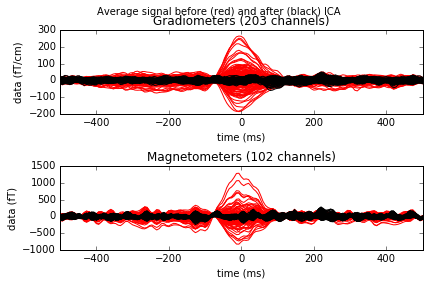

In [33]:
# plot what we would remove with this component
%matplotlib
ica.plot_overlay(eog_average, exclude=eog_inds);

Let's save our ICA

In [40]:
ica.exclude.extend(eog_inds)  # append definitions of bads
# uncomment this for reading and writing
# ica.save('my-ica.fif')
# ica = read_ica('my-ica.fif')

# Excercises
1. Now look at the EEG.
2. Which dominating artefacts do you find? Plot them.
3. Fit ICA for EEG only.
4. Inspect components. Do you find one or a few components undoubtfully related to your artefact? Use plotting for clarification
5. Identify bad components.
6. Remove them and plot the cleaned data and raw data.